In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! 7z e '/content/drive/My Drive/data.zip' -oA1_train       train_images/*.jpg
! 7z e '/content/drive/My Drive/data.zip' -oA3_trainlabels train.csv


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/                                  1 file, 1684204253 bytes (1607 MiB)

Extracting archive: /content/drive/My Drive/data.zip
 22% 4096 Open              --
Path = /content/drive/My Drive/data.zip
Type = zip
Physical Size = 1684204253

  0%      0% - train_images/0002cc93b.jpg                                   0% 40 - train_images/00bc01bfe.jpg                                      0% 63 - train_images/012d29df4.jpg                                    

In [3]:
import os
import json

import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


***Подготовим данные для обучения***

In [4]:
train_df = pd.read_csv('/content/A3_trainlabels/train.csv')
train_path = '/content/A1_train/'
train_image_names = os.listdir(train_path)
print(train_df.shape)
train_df.head()

(7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [5]:
count_class_1, count_class_2, count_class_3, count_class_4 = train_df.ClassId.value_counts()

In [6]:
df_class_1 = train_df[train_df['ClassId'] == 1]
df_class_2 = train_df[train_df['ClassId'] == 2]
df_class_3 = train_df[train_df['ClassId'] == 3]
df_class_4 = train_df[train_df['ClassId'] == 4]

Random under-sampling:
3    897
1    897
4    801
2    247
Name: ClassId, dtype: int64


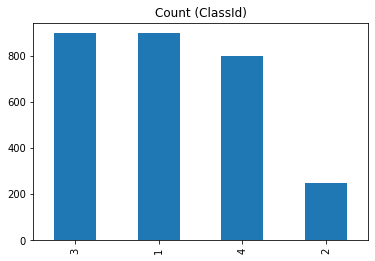

In [7]:
df_class_3_under = df_class_3.sample(count_class_2)
df_test_under = pd.concat([df_class_1, df_class_2, df_class_3_under, df_class_4], axis=0)

print('Random under-sampling:')
print(df_test_under.ClassId.value_counts())

df_test_under.ClassId.value_counts().plot(kind='bar', title='Count (ClassId)');

In [8]:
non_missing_train_idx = df_test_under
non_missing_train_idx.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
18,008ef3d74.jpg,1,356336 4 356587 11 356838 18 357089 25 357340 ...
21,00ac8372f.jpg,1,101742 3 101998 12 102253 19 102301 22 102509 ...


In [9]:
tr_img_id = []
tr_cls_id = []
for i in os.listdir(train_path):
    tr_img_id.append(i)
    tr_cls_id.append(1)
    tr_img_id.append(i)
    tr_cls_id.append(2)
    tr_img_id.append(i)
    tr_cls_id.append(3)
    tr_img_id.append(i)
    tr_cls_id.append(4)
train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
train_img_nms['ClassId'] = tr_cls_id
train_img_nms.head()

,ImageId,ClassId
0,bf9ec9501.jpg,1
1,bf9ec9501.jpg,2
2,bf9ec9501.jpg,3
3,bf9ec9501.jpg,4
4,2b09e0923.jpg,1


In [10]:
train_df = pd.merge(train_img_nms, train_df,how='outer',on=['ImageId','ClassId'])
print(train_df.shape)
train_df.head()

(50272, 3)


,ImageId,ClassId,EncodedPixels
0,bf9ec9501.jpg,1,NaN
1,bf9ec9501.jpg,2,NaN
2,bf9ec9501.jpg,3,NaN
3,bf9ec9501.jpg,4,NaN
4,2b09e0923.jpg,1,NaN


In [11]:
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()
train_df

,ImageId,ClassId,EncodedPixels,hasMask
0,bf9ec9501.jpg,1,NaN,False
1,bf9ec9501.jpg,2,NaN,False
2,bf9ec9501.jpg,3,NaN,False
3,bf9ec9501.jpg,4,NaN,False
4,2b09e0923.jpg,1,NaN,False
...,...,...,...,...
50267,a42dee222.jpg,4,11426 5 11675 14 11926 21 12180 25 12434 29 12...,True
50268,4b286bf39.jpg,1,NaN,False
50269,4b286bf39.jpg,2,NaN,False
50270,4b286bf39.jpg,3,118531 43 118787 127 119043 211 119299 254 119...,True


In [12]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 3)


,ImageId,ClassId,hasMask
10803,db4867ee8.jpg,10,3.0
11776,ef24da2ba.jpg,10,3.0
6284,7f30b9c64.jpg,10,2.0
9421,bf0c81db6.jpg,10,2.0
9615,c314f43f3.jpg,10,2.0


***Подготовим вспомогательные функции***

In [13]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [14]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

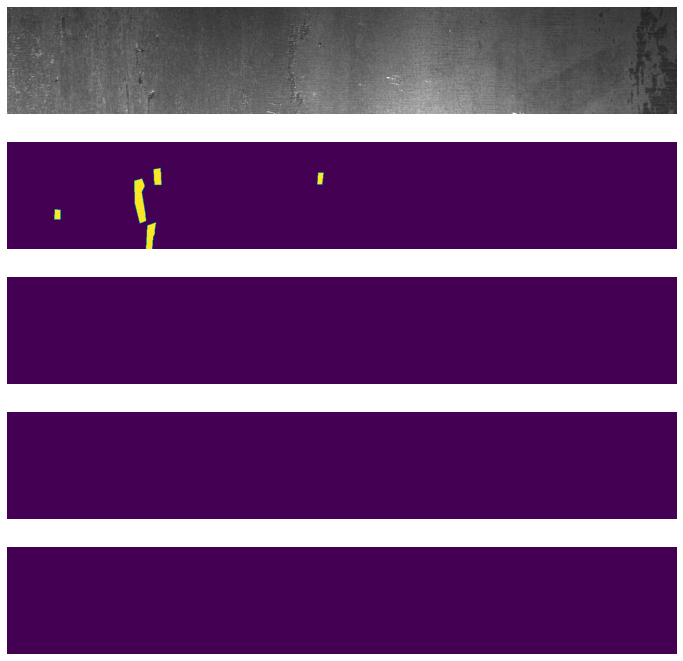

In [15]:
sample_filename = '0002cc93b.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = f"/content/A1_train/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

*** Подготовим кастомный класс DataGenerator https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly ***

In [16]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/A1_train',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

**Разбиваем данные на тренировчную и валидационную выборки**

In [17]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    non_missing_train_idx.index,
    random_state=2020, 
    test_size=0.15,
    stratify=non_missing_train_idx.ClassId	
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

**Подготавливаем модель**

In [18]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model

In [19]:
model = build_model((256, 1600, 1))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [20]:
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/unet.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=25
)

Epoch 1/25
150/150 [==============================] - 68s 455ms/step - loss: 0.1435 - dice_coef: 0.0282 - val_loss: 0.0399 - val_dice_coef: 0.0458
Epoch 2/25
150/150 [==============================] - 58s 387ms/step - loss: 0.0618 - dice_coef: 0.0420 - val_loss: 0.0445 - val_dice_coef: 0.0594
Epoch 3/25
150/150 [==============================] - 58s 389ms/step - loss: 0.0611 - dice_coef: 0.0443 - val_loss: 0.0372 - val_dice_coef: 0.0570
Epoch 4/25
150/150 [==============================] - 58s 388ms/step - loss: 0.0574 - dice_coef: 0.0566 - val_loss: 0.0362 - val_dice_coef: 0.0880
Epoch 5/25
150/150 [==============================] - 58s 390ms/step - loss: 0.0543 - dice_coef: 0.0775 - val_loss: 0.0321 - val_dice_coef: 0.0943
Epoch 6/25
150/150 [==============================] - 58s 389ms/step - loss: 0.0542 - dice_coef: 0.0812 - val_loss: 0.0292 - val_dice_coef: 0.0926
Epoch 7/25
150/150 [==============================] - 58s 387ms/step - loss: 0.0540 - dice_coef: 0.0838 - val_loss: 0.

In [ ]:
history_df = pd.DataFrame(history.history)
acc = history_df[['loss', 'val_loss']].plot()
acc.set_xlabel("Эпоха")
acc.set_ylabel("Значение функции потерь")
acc = history_df[['dice_coef', 'val_dice_coef']].plot()
acc.set_xlabel("Эпоха")
acc.set_ylabel("Значение метрики")